In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

DATA_SET = 2
if DATA_SET == 2:
    data = pd.read_csv('./data/watermelon2.txt', encoding='utf-8')
else:
    data = pd.read_csv('./data/watermelon3.txt', encoding='gbk')    

In [2]:
# Ent(D) = -sum(p * np.log2(p))
# 当p=0 p*np.log2(p)=0
def entropy(df, label='好瓜'):
    t = df.groupby([label]).size().reset_index(name='cnt')
    # 计算概率p
    t['p'] = t['cnt'] / t['cnt'].sum()
    # 下面fillna 当计算p=0时,p * np.log2(p)填充0
    return -np.sum((t['p'] * np.log2(t['p'])).fillna(0))

# 计算给定特征的Gain
# Gain(D, feat) = Ent(D) - sum(|D^v| / |D| * Ent(D^v))
def Gain(df, col):
    feat_ent = 0 # 计算特征总共的熵 sum(|D^v| / |D| * Ent(D^v))
    for feat in df[col].unique().tolist():
        t = df.query(f'{col} == "{feat}"')
        inner_ent = t.shape[0] / df.shape[0] * entropy(t) # 计算|D^v| / |D| * Ent(D^v)
        feat_ent += inner_ent
    return col, entropy(df) - feat_ent

In [3]:
tree = defaultdict(lambda : defaultdict()) # 存放所有特征的Gain信息
def create_ID3(data, tree):
    max_gain = {'feat_name':None, 'gain':-np.inf} # 存放Gain的特征
    # 获取所有的category类型特征
    columns = [col for col in data.columns.tolist() if data[col].dtype == 'object' and col != '好瓜']
    for col in columns:
        _, gain = Gain(data, col)
        if gain > max_gain['gain']:
            max_gain['feat_name'] = col
            max_gain['gain'] = gain
    tree[max_gain['feat_name']] = {}
    # 衡量这个特征下每个特征值是否还能分裂
    attrbution_list = data[max_gain['feat_name']].unique().tolist()
    for attr in attrbution_list:
        uni = data.query(f'{max_gain["feat_name"]} == "{attr}"')["好瓜"].unique().tolist()
        if len(uni) <= 1:
            tree[max_gain['feat_name']][attr] = uni[0]
        else:
            table = data.query(f"{max_gain['feat_name']} == '{attr}'").drop([max_gain['feat_name']], axis=1)
            tree[max_gain['feat_name']][attr] = dict()
            create_ID3(table, tree[max_gain['feat_name']][attr])
create_ID3(data, tree)

In [4]:
# ID3树的结构（字典形式）
tree

defaultdict(<function __main__.<lambda>>,
            {'纹理': {'模糊': '否',
              '清晰': {'根蒂': {'硬挺': '否',
                '稍蜷': {'色泽': {'乌黑': {'触感': {'硬滑': '是', '软粘': '否'}},
                  '青绿': '是'}},
                '蜷缩': '是'}},
              '稍糊': {'触感': {'硬滑': '否', '软粘': '是'}}}})

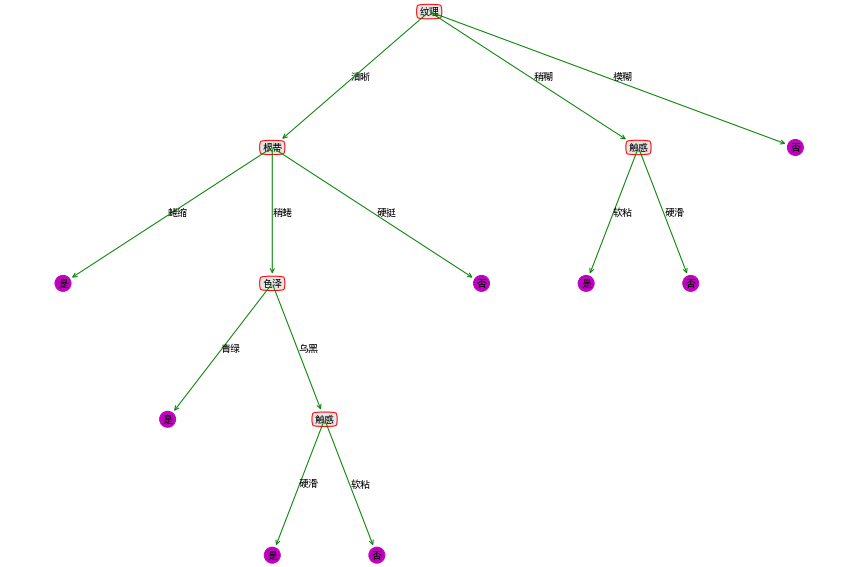

In [5]:
# -*- coding: utf-8 -*-
"""
@author: 蔚蓝的天空Tom
Aim:得到决策树的字典后，需要使用python来绘制对应的决策树figure
输入决策树的字典，样例如下所示：
dtree = {'house?': {'hourse_no': {'working?': {'work_no': 'refuse', 'work_yes': 'agree'}}, 'hourse_yes': 'agree'}}
"""
 
import matplotlib.pyplot as plt
 
#定义判断结点形状,其中boxstyle表示文本框类型,fc指的是注释框颜色的深度
decisionNode = dict(boxstyle="round4", color='r', fc='0.9')
#定义叶结点形状
leafNode = dict(boxstyle="circle", color='m')
#定义父节点指向子节点或叶子的箭头形状
arrow_args = dict(arrowstyle="<-", color='g')
 
def plot_node(node_txt, center_point, parent_point, node_style):
    '''
    绘制父子节点，节点间的箭头，并填充箭头中间上的文本
    :param node_txt:文本内容
    :param center_point:文本中心点
    :param parent_point:指向文本中心的点
    '''
    createPlot.ax1.annotate(node_txt, 
                            xy=parent_point,
                            xycoords='axes fraction',
                            xytext=center_point,
                            textcoords='axes fraction',
                            va="center",
                            ha="center",
                            bbox=node_style,
                            arrowprops=arrow_args)

def get_leafs_num(tree_dict):
    '''
    获取叶节点的个数
    :param tree_dict:树的数据字典
    :return tree_dict的叶节点总个数
    '''
    #tree_dict的叶节点总数
    leafs_num = 0
    
    #字典的第一个键，也就是树的第一个节点
    root = list(tree_dict.keys())[0]
    #这个键所对应的值，即该节点的所有子树。
    child_tree_dict =tree_dict[root]
    for key in child_tree_dict.keys():
        #检测子树是否字典型
        if type(child_tree_dict[key]).__name__=='dict':
            #子树是字典型，则当前树的叶节点数加上此子树的叶节点数
            leafs_num += get_leafs_num(child_tree_dict[key])
        else:
            #子树不是字典型，则当前树的叶节点数加1
            leafs_num += 1
 
    #返回tree_dict的叶节点总数
    return leafs_num
 
def get_tree_max_depth(tree_dict):
    '''
    求树的最深层数
    :param tree_dict:树的字典存储
    :return tree_dict的最深层数
    '''
    #tree_dict的最深层数
    max_depth = 0
    
    #树的根节点
    root = list(tree_dict.keys())[0]
    #当前树的所有子树的字典
    child_tree_dict = tree_dict[root]
    
    for key in child_tree_dict.keys():
        #树的当前分支的层数
        this_path_depth = 0
        #检测子树是否字典型
        if type(child_tree_dict[key]).__name__ == 'dict':
            #如果子树是字典型，则当前分支的层数需要加上子树的最深层数
            this_path_depth = 1 + get_tree_max_depth(child_tree_dict[key])
        else:
            #如果子树不是字典型，则是叶节点，则当前分支的层数为1
            this_path_depth = 1
        if this_path_depth > max_depth:
            max_depth = this_path_depth
    
    #返回tree_dict的最深层数
    return max_depth
 
def plot_mid_text(center_point, parent_point, txt_str):
    '''
    计算父节点和子节点的中间位置，并在父子节点间填充文本信息
    :param center_point:文本中心点
    :param parent_point:指向文本中心点的点
    '''
    
    x_mid = (parent_point[0] - center_point[0])/2.0 + center_point[0]
    y_mid = (parent_point[1] - center_point[1])/2.0 + center_point[1]
    createPlot.ax1.text(x_mid, y_mid, txt_str)
    return
 
def plotTree(tree_dict, parent_point, node_txt):
    '''
    绘制树
    :param tree_dict:树
    :param parent_point:父节点位置
    :param node_txt:节点内容
    '''
    
    leafs_num = get_leafs_num(tree_dict)
    root = list(tree_dict.keys())[0]
    #plotTree.totalW表示树的深度
    center_point = (plotTree.xOff+(1.0+float(leafs_num))/2.0/plotTree.totalW,plotTree.yOff)
    #填充node_txt内容
    plot_mid_text(center_point, parent_point, node_txt)
    #绘制箭头上的内容
    plot_node(root, center_point, parent_point, decisionNode)
    #子树
    child_tree_dict = tree_dict[root]
    plotTree.yOff=plotTree.yOff-1.0/plotTree.totalD
    #因从上往下画，所以需要依次递减y的坐标值，plotTree.totalD表示存储树的深度
    for key in child_tree_dict.keys():
        if type(child_tree_dict[key]).__name__ == 'dict':
            plotTree(child_tree_dict[key],center_point,str(key))
        else:
            plotTree.xOff=plotTree.xOff+1.0/plotTree.totalW
            plot_node(child_tree_dict[key],(plotTree.xOff,plotTree.yOff),center_point,leafNode)
            plot_mid_text((plotTree.xOff,plotTree.yOff),center_point,str(key))
    #h绘制完所有子节点后，增加全局变量Y的偏移
    plotTree.yOff=plotTree.yOff+1.0/plotTree.totalD
 
    return
 
def createPlot(tree_dict):
    '''
    绘制决策树图形
    :param tree_dict
    :return 无
    '''
    #设置绘图区域的背景色
    fig=plt.figure(1,facecolor='white', figsize=(15, 10))
    #清空绘图区域
    fig.clf()
    #定义横纵坐标轴,注意不要设置xticks和yticks的值!!!
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1=plt.subplot(111, frameon=False, **axprops)
    #由全局变量createPlot.ax1定义一个绘图区，111表示一行一列的第一个，frameon表示边框,**axprops不显示刻度
    plotTree.totalW=float(get_leafs_num(tree_dict))
    plotTree.totalD=float(get_tree_max_depth(tree_dict))
    plotTree.xOff=-0.5/plotTree.totalW;
    plotTree.yOff=1.0;
    plotTree(tree_dict, (0.5,1.0), '')
    plt.show()
    

tree_dict = {'house?': {'hourse_no': {'working?': {'work_no': 'refuse', 'work_yes': 'agree'}}, 'hourse_yes': 'agree'}}
createPlot(tree)

In [9]:
# 备忘录版本的斐波那契数列
a = dict()
def fib(x):
    if x in [0, 1]:
        return 1
    if x in a.keys():
        return a[x]
    else:
        a[x] = fib(x - 1) + fib(x - 2)
    return a[x]
fib(200)

453973694165307953197296969697410619233826